In [319]:
import pickle
import copy

import alphashape as ashp
import pandas as pd
import numpy as np
import colorcet as cc
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import block_diag
from filterpy.kalman import KalmanFilter, MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

from tqdm import tqdm
from matplotlib import colors
from pyproj import Proj

In [320]:
plt.style.use('dark_background')

In [321]:
H5_PATH = '/home/yang/output/eswe/cls/'
OUTPUT_PATH = '/home/yang/output/eswe/smooth/'
EVENT = 'jkwh'
MACHINE_ID = '6088'
DATE = '072019'
FIELD_ID = 'f8'
log_name = '-'.join([EVENT, MACHINE_ID, DATE, FIELD_ID, 'gps-cls.h5'])

In [322]:
# Load in data
gps = pd.read_hdf(H5_PATH + log_name)

In [323]:
gps.head()

,machine_id,ts,lat,lon,alt,speed,track,accuracies,x,y,ts_local,cv_prob,nct_prob,mode
0,Joe 6088,1297319691,40.779603,-102.323489,1156.000000,2.061553,13.8,5,725859.029481,4.517738e+06,2011-02-09 23:34:51,0.499834,0.500166,w
1,Joe 6088,1297319692,40.779624,-102.323562,1154.099976,1.500000,2.8,4,725852.777364,4.517741e+06,2011-02-09 23:34:52,0.550161,0.449839,w
2,Joe 6088,1297319693,40.779594,-102.323562,1146.000000,1.500000,2.7,3,725852.926930,4.517737e+06,2011-02-09 23:34:53,0.765277,0.234723,w
3,Joe 6088,1297319694,40.779619,-102.323589,1145.300049,1.500000,1.1,3,725850.556938,4.517740e+06,2011-02-09 23:34:54,0.991535,0.008465,w
4,Joe 6088,1563488097,40.778486,-102.325116,1144.599976,0.750000,92.6,3,725725.518647,4.517610e+06,2019-07-18 16:14:57,0.942039,0.057961,w


(725645.8757153526, 726135.5715363597, 4517530.146109972, 4519291.243203093)

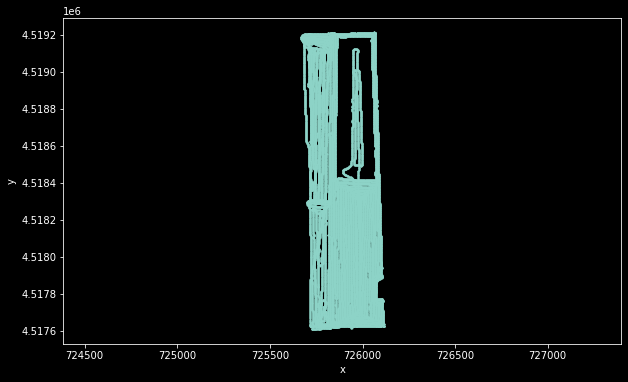

In [324]:
fig, ax = plt.subplots(figsize=(10,6))
gps.plot.scatter(x='x', y='y', s=1, ax=ax)
ax.axis('equal')

In [325]:
# Before smoothing, let's see if there is any gap in data points
# We need to break these different segments into groups and then smooth each group

# Take out the working class only
gps_seg = gps[gps['mode'] == 'w'].copy()
# Compute time difference
gps_seg['ts_diff'] = gps_seg['ts'].diff()
gps_seg.loc[0, 'ts_diff'] = 0

# A trick vector that could be used for grouping
gps_seg['ts_diff_binary'] = gps_seg['ts_diff'] > 1
gps_seg['ts_diff_binary_cumsum'] = gps_seg['ts_diff_binary'].apply(lambda x: 1 if x else 0).cumsum()

# Points groups
grp = gps_seg.groupby('ts_diff_binary_cumsum')

# Make indices right
gps_seg['seg_num'] = grp.ngroup()
gps_seg.loc[0, 'seg_num'] = 0

In [326]:
print(gps_seg['seg_num'].unique())

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194]


In [327]:
# Allocate space for smoothed x, y
gps_s = gps[gps['mode'] == 'w'].copy()
gps_s['xs'] = np.nan
gps_s['ys'] = np.nan

In [328]:
# For non-working samples, don't smooth them
gps_s_nw = gps[gps['mode'] != 'w'].copy()
gps_s_nw['xs'] = np.nan
gps_s_nw['ys'] = np.nan
gps_s_nw.loc[gps_s_nw[gps_s_nw['mode'] != 'w'].index, 'xs'] = gps_s_nw.loc[gps_s_nw[gps_s_nw['mode'] != 'w'].index, 'x']
gps_s_nw.loc[gps_s_nw[gps_s_nw['mode'] != 'w'].index, 'ys'] = gps_s_nw.loc[gps_s_nw[gps_s_nw['mode'] != 'w'].index, 'y']

In [329]:
# Define CA Kalman filter
dt = 1
r = 9 # 9 seems to be the magic value
ca = KalmanFilter(6, 2)
dt2 = (dt**2)/2
F = np.array([[1, dt, dt2],
              [0,  1,  dt],
              [0,  0,   1]])
            
ca.F = block_diag(F, F)
ca.P *= 1e-6
ca.R *= r**2
q = np.array([[.05, .125, 1/6],
              [.125, 1/3, .5],
              [1/6, .5, 1]])*1.e-2
ca.Q = block_diag(q, q)
ca.H = np.array([[1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0]])

In [330]:
for n in tqdm(gps_seg['seg_num'].unique()):
    # Get the track segment
    seg = gps_s.loc[gps_seg['seg_num'] == n, ['x', 'y']]
    z = np.vstack([seg['x'].values, seg['y'].values]).T
    # Filter data with CA Kalman filter, than run smoother on it
    ca.x = np.array([z[0,0], 0, 0, z[0,1], 0, 0])
    mu, cov, _, _ = ca.batch_filter(z)
    xs, Ps, C, _ = ca.rts_smoother(mu, cov)
    # Assign the smoothed estimates to the original df
    gps_s.loc[gps_seg['seg_num'] == n, 'xs'] = xs[:,0]
    gps_s.loc[gps_seg['seg_num'] == n, 'ys'] = xs[:,3]

100%|██████████| 195/195 [00:06<00:00, 30.08it/s]


In [331]:
gps_s_f = pd.concat([gps_s, gps_s_nw])

In [332]:
gps_s_f = gps_s_f.sort_values(by='ts').reset_index(drop=True)

(725645.8757153526, 726135.5715363597, 4517530.146109972, 4519291.243203093)

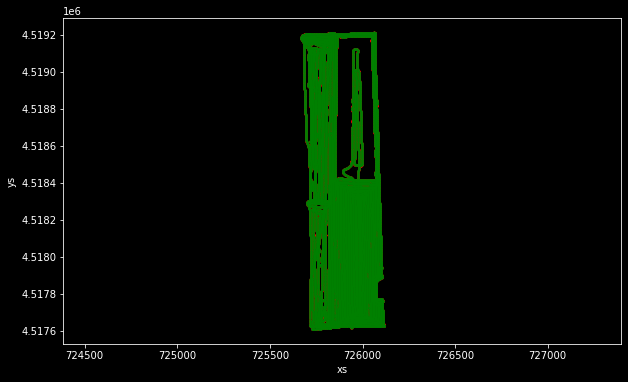

In [333]:
# %matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))
gps_s_f.plot.scatter(x='x', y='y', c='r', s=1, ax=ax)
gps_s_f.plot.scatter(x='xs', y='ys', c='g', s=1, ax=ax)
ax.axis('equal')

In [334]:
gps_s_f.to_hdf(OUTPUT_PATH + '-'.join([EVENT, MACHINE_ID, DATE, FIELD_ID, 'gps-sm.h5']), \
             data_columns=['ts', 'xs', 'ys'], \
             key='df', mode='w')